In [3]:
import pandas as pd
import seaborn as sns
import json
import os
import re
import shutil
from datetime import datetime

data_out_dir = "./data/tables"

def convert_to_datetime_format(input):
    input_string = str(input)
    try:
        # If the input is a valid timestamp in milliseconds (10+ digits), convert it
        if len(input_string) > 10:  # it's in milliseconds
            timestamp = int(input_string) / 1000
        else:  # It's in seconds
            timestamp = int(input_string)

        # Convert the timestamp to a datetime object
        dt_object = datetime.utcfromtimestamp(timestamp)

        # Return the formatted string
        return dt_object.strftime('%Y-%m-%d %H:%M')
    
    except ValueError:
        # If input is in "YYYY-MM-DD HH:mm" format already, return it unchanged
        try:
            datetime.strptime(input_string, "%Y-%m-%d %H:%M")
            return input_string
        except ValueError:
            raise ValueError("Invalid input format")

def normalize_csv_timestamps(csv_path):
    """
    Normalize the first column of a CSV file to Unix timestamps with second precision.
    
    Args:
        csv_path: Path to the CSV file to normalize
    
    Returns:
        DataFrame with normalized timestamps and mapping from original to normalized
    """
    # Read the CSV
    df = pd.read_csv(csv_path)
    
    # Get the first column name
    time_col = df.columns[0]
    
    # Try to parse the time column
    try:
        # Try parsing as datetime first (handles formats like "2025-07-27 21:02")
        df[time_col] = df[time_col].apply(convert_to_datetime_format)
    except:
        print(f"Warning: Could not parse time column in {csv_path}")
        return df, {}
        
    # Save the normalized CSV
    df.to_csv(csv_path, index=False)
    
    # Create mapping: row index -> timestamp
    timestamp_map = {idx: ts for idx, ts in enumerate(df[time_col])}
    
    return df, timestamp_map

def handle_labels_in_single_file(labels_in_file_json: json, labels_json: json, current_input_dir, next_file_id):
    # Ensure output structure
    if 'files' not in labels_json:
        labels_json['files'] = []
    if 'labels' not in labels_json:
        labels_json['labels'] = []

    # Skip file if it has 0 annotations
    annotations = labels_in_file_json.get('annotations', []) if isinstance(labels_in_file_json, dict) else []
    if not annotations or len(annotations) == 0:
        return next_file_id
    label_count = sum(len(a.get('result', [])) for a in annotations)
    if label_count < 1: 
        return next_file_id

    # determine file path
    file_path = None
    if isinstance(labels_in_file_json, dict):
        file_path = labels_in_file_json.get('file_upload') or labels_in_file_json.get('data', {}).get('csv')
    if not file_path:
        raise ValueError("Cannot determine file path for input file JSON")

    # Parse filename to match pattern: SYMBOL_Xmin_INDEX.csv or SYMBOL_XH_INDEX.csv
    # May have optional prefix like: 351f4d2a-EURUSD_1H_005.csv
    filename = os.path.basename(file_path)
    
    # Pattern: (optional_prefix-)SYMBOL_(number)(unit)_(index).csv
    # Examples: EURUSD_1min_001.csv, XAU_1H_001.csv, EURUSD_15min_003.csv, 351f4d2a-EURUSD_1H_005.csv
    pattern = r'^(?:[a-zA-Z0-9]+-)?([A-Z]+)_(\d+)(min|H)_(\d+)\.csv$'
    match = re.match(pattern, filename)
    
    if not match:
        print(f"Warning: File path doesn't match expected pattern, discarding: {file_path}")
        return next_file_id
    
    symbol = match.group(1)
    timestep_count = int(match.group(2))
    unit_raw = match.group(3)
    original_index = int(match.group(4))
    
    # Normalize unit
    if unit_raw == 'min':
        timestep_unit = 'min'
    elif unit_raw == 'H':
        timestep_unit = 'H'
    else:
        timestep_unit = unit_raw

    normalized_filename = f"{symbol}_{timestep_count}{timestep_unit}_{original_index:03d}.csv"
    
    # Check if file exists in current_input_dir
    full_file_path = os.path.join(current_input_dir, normalized_filename)
    if not os.path.isfile(full_file_path):
        print(f"Warning: File not found in {current_input_dir}, discarding: {full_file_path}")
        return next_file_id
    
    # Find lowest available 3-digit index for normalized path
    normalized_index = 1
    while True:
        normalized_filename = f"{symbol}_{timestep_count}{timestep_unit}_{normalized_index:03d}.csv"
        normalized_path = os.path.join(data_out_dir, normalized_filename)
        
        # Check if this normalized path already exists in our output structure
        existing = next((f for f in labels_json['files'] if f.get('normalized_file') == normalized_filename), None)
        
        # Also check if file physically exists in data_out_dir
        if existing is None and not os.path.exists(normalized_path):
            break
        
        normalized_index += 1
        if normalized_index > 999:
            raise ValueError(f"Cannot find available index for {symbol}_{timestep_count}{timestep_unit}")
        
    # check if original file path already present
    existing = next((f for f in labels_json['files'] if f.get('normalized_file') == normalized_filename), None)
    if existing is None:
        # count labels available in this file (sum of result lengths)
        label_count = sum(len(a.get('result', [])) for a in annotations)

        # Copy original file from current_input_dir to data_out_dir with normalized filename
        os.makedirs(data_out_dir, exist_ok=True)
        shutil.copy2(full_file_path, normalized_path)
        print(f"Copied {full_file_path} -> {normalized_path}")
        
        # Normalize timestamps in the CSV file
        df, timestamp_map = normalize_csv_timestamps(normalized_path)

        file_entry = {
            'id': next_file_id,
            'file': full_file_path,
            'normalized_file': normalized_filename,
            'symbol': symbol,
            'timestep_count': timestep_count,
            'timestep_unit': timestep_unit,
            'label_count': label_count
        }
        labels_json['files'].append(file_entry)
        file_id = next_file_id
        next_file_id += 1
    else:
        file_id = existing['id']
        # Load timestamp map for existing file
        normalized_path = os.path.join(data_out_dir, normalized_filename)
        df = pd.read_csv(normalized_path)
        time_col = df.columns[0]
        timestamp_map = {idx: ts for idx, ts in enumerate(df[time_col])}

    # helper to normalize type/subtype
    def split_label(lbl: str):
        if not lbl:
            return ('unknown', '')
        parts = lbl.strip().split()
        t = parts[0].lower()
        subtype = ' '.join(parts[1:]).lower() if len(parts) > 1 else ''
        # normalize common tokens
        if t.startswith('bull'):
            t = 'bullish'
        elif t.startswith('bear'):
            t = 'bearish'
        return (t, subtype)

    # extract individual timeserieslabels
    for ann in annotations:
        for res in ann.get('result', []):
            if res.get('type') != 'timeserieslabels':
                continue
            val = res.get('value', {})
            start = val.get('start')
            end = val.get('end')
            instant = val.get('instant', False)
            ts_labels = val.get('timeserieslabels', []) or []

            # Normalize start and end using the timestamp map
            # start and end are row indices from Label Studio
            normalized_start = timestamp_map.get(start, start) if start is not None else None
            normalized_end = timestamp_map.get(end, end) if end is not None else None

            # create one output label per timeseries label in the result
            for ts_label in ts_labels:
                t, subtype = split_label(ts_label)
                label_entry = {
                    'file': file_id,
                    'start': convert_to_datetime_format(start),
                    'end': convert_to_datetime_format(end),
                    'instant': instant,
                    'type': t,
                    'subtype': subtype
                }
                labels_json['labels'].append(label_entry)

    return next_file_id

def convert_labels(out_labels_json: json, labels_json: json, current_input_dir: str, next_file_id = 0):
    """
    Convert labels from Label Studio export format to the custom output format.
    
    Args:
        out_labels_json: Dictionary to populate with converted labels (modified in-place)
        labels_json: List of Label Studio task objects from the export JSON
        next_file_id: Starting file ID (default 0)
    
    Returns:
        The next available file_id after processing
    """
    # Ensure labels_json is a list
    if not isinstance(labels_json, list):
        raise ValueError("labels_json must be a list of Label Studio task objects")
    
    # Process each task in the input
    for task in labels_json:
        if not isinstance(task, dict):
            continue
        next_file_id = handle_labels_in_single_file(task, out_labels_json, current_input_dir, next_file_id)
    
    return next_file_id

def merge_and_convert_labels(input_dir: str):
    """
    Merge and convert all labels.json files from subdirectories of input_dir.
    
    Args:
        input_dir: Root directory containing subdirectories with labels.json files
    
    Returns:
        Dictionary with merged labels in the custom format
    """
    import os
    
    next_file_id = 0
    out_labels_json = {}
    
    # Check if input_dir exists
    if not os.path.isdir(input_dir):
        raise ValueError(f"Input directory does not exist: {input_dir}")
    
    # Iterate through subdirectories
    for subdir_name in os.listdir(input_dir):
        subdir_path = os.path.join(input_dir, subdir_name)
        
        # Skip if not a directory
        if not os.path.isdir(subdir_path):
            continue
        
        # Look for labels.json in this subdirectory
        labels_file = os.path.join(subdir_path, 'labels.json')
        if not os.path.isfile(labels_file):
            print(f"Warning: No labels.json found in {subdir_path}")
            continue
        
        # Load and convert labels from this file
        try:
            with open(labels_file, 'r', encoding='utf-8') as f:
                input_labels = json.load(f)
            
            next_file_id = convert_labels(out_labels_json, input_labels, subdir_path, next_file_id)
            print(f"Processed {labels_file}: {len(out_labels_json.get('labels', []))} total labels")
        except Exception as e:
            print(f"Error processing {labels_file}: {e}")
    
    return out_labels_json

def remove_closed_exchange_periods_and_volume(data_dir):
    """
    Remove long stretches of unchanged OHLC values (closed exchange periods) from CSV files,
    keeping only the first and last data point of each stretch. Also removes volume column if present.
    
    Args:
        data_dir: Directory containing CSV files to process
    """
    if not os.path.isdir(data_dir):
        print(f"Warning: Directory {data_dir} does not exist")
        return
    
    # Iterate through all CSV files in the directory
    for filename in os.listdir(data_dir):
        if not filename.endswith('.csv'):
            continue
        
        filepath = os.path.join(data_dir, filename)
        
        try:
            # Read the CSV
            df = pd.read_csv(filepath)
            
            # Remove volume column if it exists
            volume_cols = [col for col in df.columns if col.lower() == 'volume']
            if volume_cols:
                df = df.drop(columns=volume_cols)
            
            # Ensure we have the expected columns
            if not all(col in df.columns for col in ['open', 'high', 'low', 'close']):
                print(f"Warning: {filename} missing required columns, skipping")
                continue
            
            if len(df) <= 2:
                # Not enough rows to have a stretch in the middle
                df.to_csv(filepath, index=False)
                continue
            
            # Identify rows that differ from the previous row
            df['changed'] = (
                (df['open'] != df['open'].shift(1)) |
                (df['high'] != df['high'].shift(1)) |
                (df['low'] != df['low'].shift(1)) |
                (df['close'] != df['close'].shift(1))
            )
            
            # First row is always considered changed (no previous row to compare)
            df.loc[0, 'changed'] = True
            
            # Mark rows where the NEXT row is different (end of a stretch)
            df['next_changed'] = df['changed'].shift(-1).fillna(True)
            
            # Keep rows that are either:
            # 1. Different from previous (start of a new value period)
            # 2. Have a different next row (end of a value period)
            rows_to_keep = df['changed'] | df['next_changed']
            
            df_filtered = df[rows_to_keep].drop(columns=['changed', 'next_changed'])
            
            removed_count = len(df) - len(df_filtered)
            df_filtered.to_csv(filepath, index=False)
            
            if removed_count > 0:
                print(f"Processed {filename}: removed {removed_count} rows from closed exchange periods")
            
        except Exception as e:
            print(f"Error processing {filename}: {e}")

labels = merge_and_convert_labels("../data")

#remove_closed_exchange_periods_and_volume("./data/tables")

# Remove files with 0 labels from json
if 'files' in labels:
    files_with_labels = [f for f in labels['files'] if f.get('label_count', 0) > 0]
    removed_count = len(labels['files']) - len(files_with_labels)
    labels['files'] = files_with_labels
    if removed_count > 0:
        print(f"Removed {removed_count} file(s) with 0 labels")

with open("./data/labels.json", "w", encoding="utf-8") as f:
    json.dump(labels, f)

Copied ../data\AS76HW\XAU_1H_001.csv -> ./data/tables\XAU_1H_001.csv
Copied ../data\AS76HW\XAU_1min_001.csv -> ./data/tables\XAU_1min_001.csv
Copied ../data\AS76HW\XAU_5min_001.csv -> ./data/tables\XAU_5min_001.csv
Copied ../data\AS76HW\XAU_15min_001.csv -> ./data/tables\XAU_15min_001.csv
Copied ../data\AS76HW\XAU_30min_001.csv -> ./data/tables\XAU_30min_001.csv
Processed ../data\AS76HW\labels.json: 58 total labels
Copied ../data\AY1PC8\EURUSD_1H_005.csv -> ./data/tables\EURUSD_1H_001.csv
Copied ../data\AY1PC8\EURUSD_1min_001.csv -> ./data/tables\EURUSD_1min_001.csv
Processed ../data\AY1PC8\labels.json: 135 total labels
Copied ../data\DMQSIV_1\EURUSD_15min_001.csv -> ./data/tables\EURUSD_15min_001.csv
Processed ../data\DMQSIV_1\labels.json: 187 total labels
Processed ../data\DMQSIV_2\labels.json: 187 total labels
Copied ../data\DO1H50\EURUSD_1H_001.csv -> ./data/tables\EURUSD_1H_002.csv
Copied ../data\DO1H50\EURUSD_1min_001.csv -> ./data/tables\EURUSD_1min_002.csv
Processed ../data\DO1

https://bmeedu-my.sharepoint.com/:f:/g/personal/gyires-toth_balint_vik_bme_hu/IgC46gsvi2lmQqa2rGfChhjEAUsBnZtFVwvoK0dolBUfIAM?e=serdFI

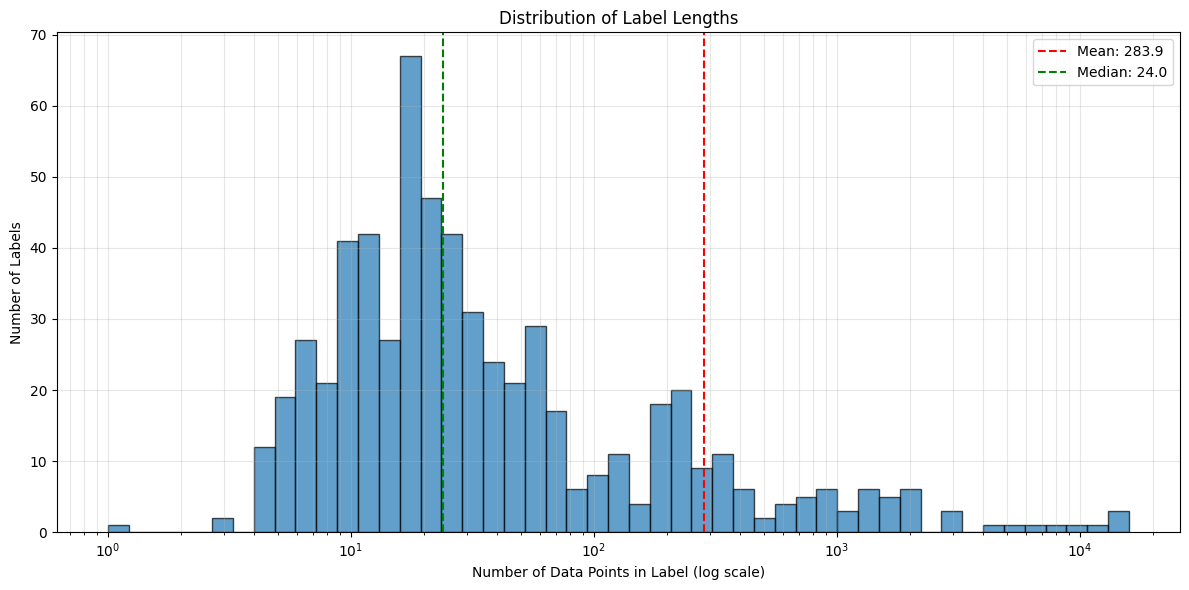

Total labels: 612
Mean length: 283.92
Median length: 24.00
Min length: 1
Max length: 15943


In [5]:
# Draw graph where the x axis is the number of data points in a label and the y is the number of different labels with similar length
# To get data points of a given label, first find the file which belongs to the label, next find the indices of the datapoints nearest to start and end of the label,
#  then cut between these to a dataframe and get its length

import matplotlib.pyplot as plt
import numpy as np

data_dir = "./data"
labels_path = data_dir + "/labels.json"

def get_dataframe_of_label(single_label: dict, files: list):
    """
    Get the dataframe slice corresponding to a single label.
    
    Args:
        single_label: Label dictionary with 'file', 'start', 'end' keys
        files: List of file dictionaries from labels.json
    
    Returns:
        DataFrame slice for this label, or None if error
    """
    try:
        # Find the file entry
        file_id = single_label['file']
        file_entry = next((f for f in files if f['id'] == file_id), None)
        
        if not file_entry:
            return None
        
        # Load the CSV file
        csv_path = os.path.join(data_out_dir, file_entry['normalized_file'])
        if not os.path.exists(csv_path):
            return None
        
        df = pd.read_csv(csv_path)
        
        # Get start and end timestamps
        start_ts = single_label.get('start')
        end_ts = single_label.get('end')
        
        if start_ts is None or end_ts is None:
            return None
        
        # Get the time column
        time_col = df.columns[0]
        
        # Find rows between start and end (inclusive)
        mask = (df[time_col] >= start_ts) & (df[time_col] <= end_ts)
        return df[mask]
        
    except Exception as e:
        print(f"Error processing label: {e}")
        return None

def collect_lengths(labels_json: dict):
    """
    Collect the lengths (number of data points) of all labels.
    
    Args:
        labels_json: Dictionary with 'labels' and 'files' keys
    
    Returns:
        List of label lengths
    """
    labels = labels_json.get("labels", [])
    files = labels_json.get("files", [])
    
    lengths = []
    for label in labels:
        df = get_dataframe_of_label(label, files)
        if df is not None and len(df) > 0:
            lengths.append(len(df))
    
    return lengths

def draw_graph(labels_json: dict):
    """
    Draw histogram of label lengths with logarithmic x-axis.
    
    Args:
        labels_json: Dictionary with 'labels' and 'files' keys
    """
    lengths = collect_lengths(labels_json)
    
    if not lengths:
        print("No valid label lengths to plot")
        return
    
    plt.figure(figsize=(12, 6))
    
    # Use logarithmic bins for better visualization
    min_len = max(1, min(lengths))  # Avoid log(0)
    max_len = max(lengths)
    bins = np.logspace(np.log10(min_len), np.log10(max_len), 50)
    
    plt.hist(lengths, bins=bins, edgecolor='black', alpha=0.7)
    plt.xscale('log')
    plt.xlabel('Number of Data Points in Label (log scale)')
    plt.ylabel('Number of Labels')
    plt.title('Distribution of Label Lengths')
    plt.grid(True, alpha=0.3, which='both')
    
    # Add statistics
    mean_len = sum(lengths) / len(lengths)
    median_len = sorted(lengths)[len(lengths) // 2]
    plt.axvline(mean_len, color='red', linestyle='--', label=f'Mean: {mean_len:.1f}')
    plt.axvline(median_len, color='green', linestyle='--', label=f'Median: {median_len:.1f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Total labels: {len(lengths)}")
    print(f"Mean length: {mean_len:.2f}")
    print(f"Median length: {median_len:.2f}")
    print(f"Min length: {min(lengths)}")
    print(f"Max length: {max(lengths)}")

# Load the labels and draw the graph
with open(labels_path, 'r', encoding='utf-8') as f:
    labels_data = json.load(f)

draw_graph(labels_data)

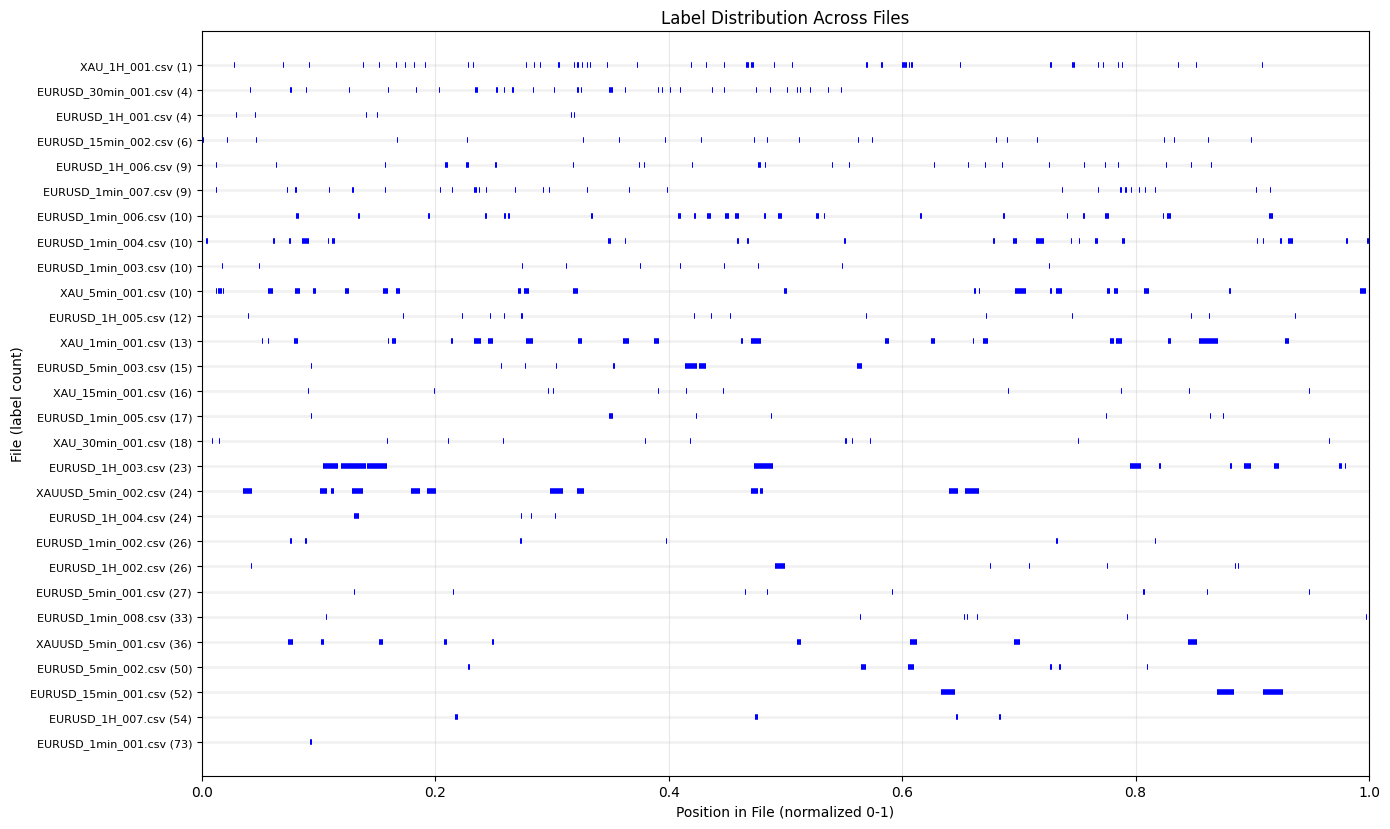


Summary:
Total files with labels: 28
Average labels per file: 21.86

Potential incomplete labeling detected in 1 files:
  XAU_1H_001.csv: labels only in range 0.09-0.09


In [7]:
# I'm a bit worried that some files were not labeled all the way through, so they contain some false negative data
# i want to visualize this somehow on a graph which shows the distribution of labels in files for each file

def analyze_label_coverage_per_file(labels_json: dict):
    """
    Analyze how labels are distributed across each file.
    Returns a dictionary mapping file_id to label coverage information.
    """
    labels = labels_json.get("labels", [])
    files = labels_json.get("files", [])
    
    # Group labels by file
    labels_by_file = {}
    for label in labels:
        file_id = label['file']
        if file_id not in labels_by_file:
            labels_by_file[file_id] = []
        labels_by_file[file_id].append(label)
    
    # Calculate coverage for each file
    file_coverage = {}
    for file_entry in files:
        file_id = file_entry['id']
        if file_id not in labels_by_file:
            continue
        
        # Load the CSV to get total length
        csv_path = os.path.join(data_out_dir, file_entry['normalized_file'])
        if not os.path.exists(csv_path):
            continue
        
        df = pd.read_csv(csv_path)
        time_col = df.columns[0]
        
        # Convert timestamps to datetime for calculations
        df[time_col] = pd.to_datetime(df[time_col])
        
        file_start = df[time_col].iloc[0]
        file_end = df[time_col].iloc[-1]
        total_duration = (file_end - file_start).total_seconds() if file_end != file_start else 1
        
        # Collect label positions (normalized to 0-1 range)
        label_positions = []
        for label in labels_by_file[file_id]:
            start_ts = label.get('start')
            end_ts = label.get('end')
            
            if start_ts and end_ts:
                try:
                    # Parse datetime strings
                    start_dt = pd.to_datetime(start_ts)
                    end_dt = pd.to_datetime(end_ts)
                    
                    # Normalize to 0-1 range
                    norm_start = (start_dt - file_start).total_seconds() / total_duration if total_duration > 0 else 0
                    norm_end = (end_dt - file_start).total_seconds() / total_duration if total_duration > 0 else 0
                    label_positions.append((norm_start, norm_end))
                except:
                    continue
        
        file_coverage[file_id] = {
            'normalized_file': file_entry['normalized_file'],
            'label_count': len(labels_by_file[file_id]),
            'label_positions': label_positions,
            'file_start': file_start,
            'file_end': file_end
        }
    
    return file_coverage

def draw_label_distribution_graph(labels_json: dict):
    """
    Draw a graph showing label distribution across files.
    Each row represents a file, with labels shown as horizontal bars.
    """
    coverage = analyze_label_coverage_per_file(labels_json)
    
    if not coverage:
        print("No coverage data to plot")
        return
    
    # Sort files by label count for better visualization
    sorted_files = sorted(coverage.items(), key=lambda x: x[1]['label_count'], reverse=True)
    
    # Limit to top 30 files for readability
    top_n = 30
    if len(sorted_files) > top_n:
        sorted_files = sorted_files[:top_n]
        print(f"Showing top {top_n} files with most labels")
    
    fig, ax = plt.subplots(figsize=(14, max(8, len(sorted_files) * 0.3)))
    
    for idx, (file_id, data) in enumerate(sorted_files):
        y_pos = len(sorted_files) - idx - 1  # Reverse order for top-to-bottom
        
        # Draw a background line for the entire file
        ax.plot([0, 1], [y_pos, y_pos], 'lightgray', linewidth=2, alpha=0.3)
        
        # Draw each label as a horizontal bar
        for start, end in data['label_positions']:
            ax.plot([start, end], [y_pos, y_pos], 'b', linewidth=4, solid_capstyle='butt')
    
    # Set labels
    ax.set_yticks(range(len(sorted_files)))
    ax.set_yticklabels([f"{data['normalized_file']} ({data['label_count']})" 
                         for _, data in sorted_files], fontsize=8)
    ax.set_xlabel('Position in File (normalized 0-1)')
    ax.set_ylabel('File (label count)')
    ax.set_title('Label Distribution Across Files')
    ax.set_xlim(0, 1)
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    total_files = len(coverage)
    avg_labels = sum(d['label_count'] for d in coverage.values()) / total_files if total_files > 0 else 0
    
    print(f"\nSummary:")
    print(f"Total files with labels: {total_files}")
    print(f"Average labels per file: {avg_labels:.2f}")
    
    # Check for potential incomplete labeling
    sparse_files = []
    for file_id, data in coverage.items():
        if data['label_positions']:
            # Check if all labels are in first or last 20% of file
            starts = [pos[0] for pos in data['label_positions']]
            ends = [pos[1] for pos in data['label_positions']]
            
            if max(ends) < 0.3 or min(starts) > 0.7:
                sparse_files.append((data['normalized_file'], min(starts), max(ends)))
    
    if sparse_files:
        print(f"\nPotential incomplete labeling detected in {len(sparse_files)} files:")
        for filename, min_pos, max_pos in sparse_files[:10]:
            print(f"  {filename}: labels only in range {min_pos:.2f}-{max_pos:.2f}")

# Load the labels and draw the distribution graph
with open(labels_path, 'r', encoding='utf-8') as f:
    labels_data = json.load(f)

draw_label_distribution_graph(labels_data)

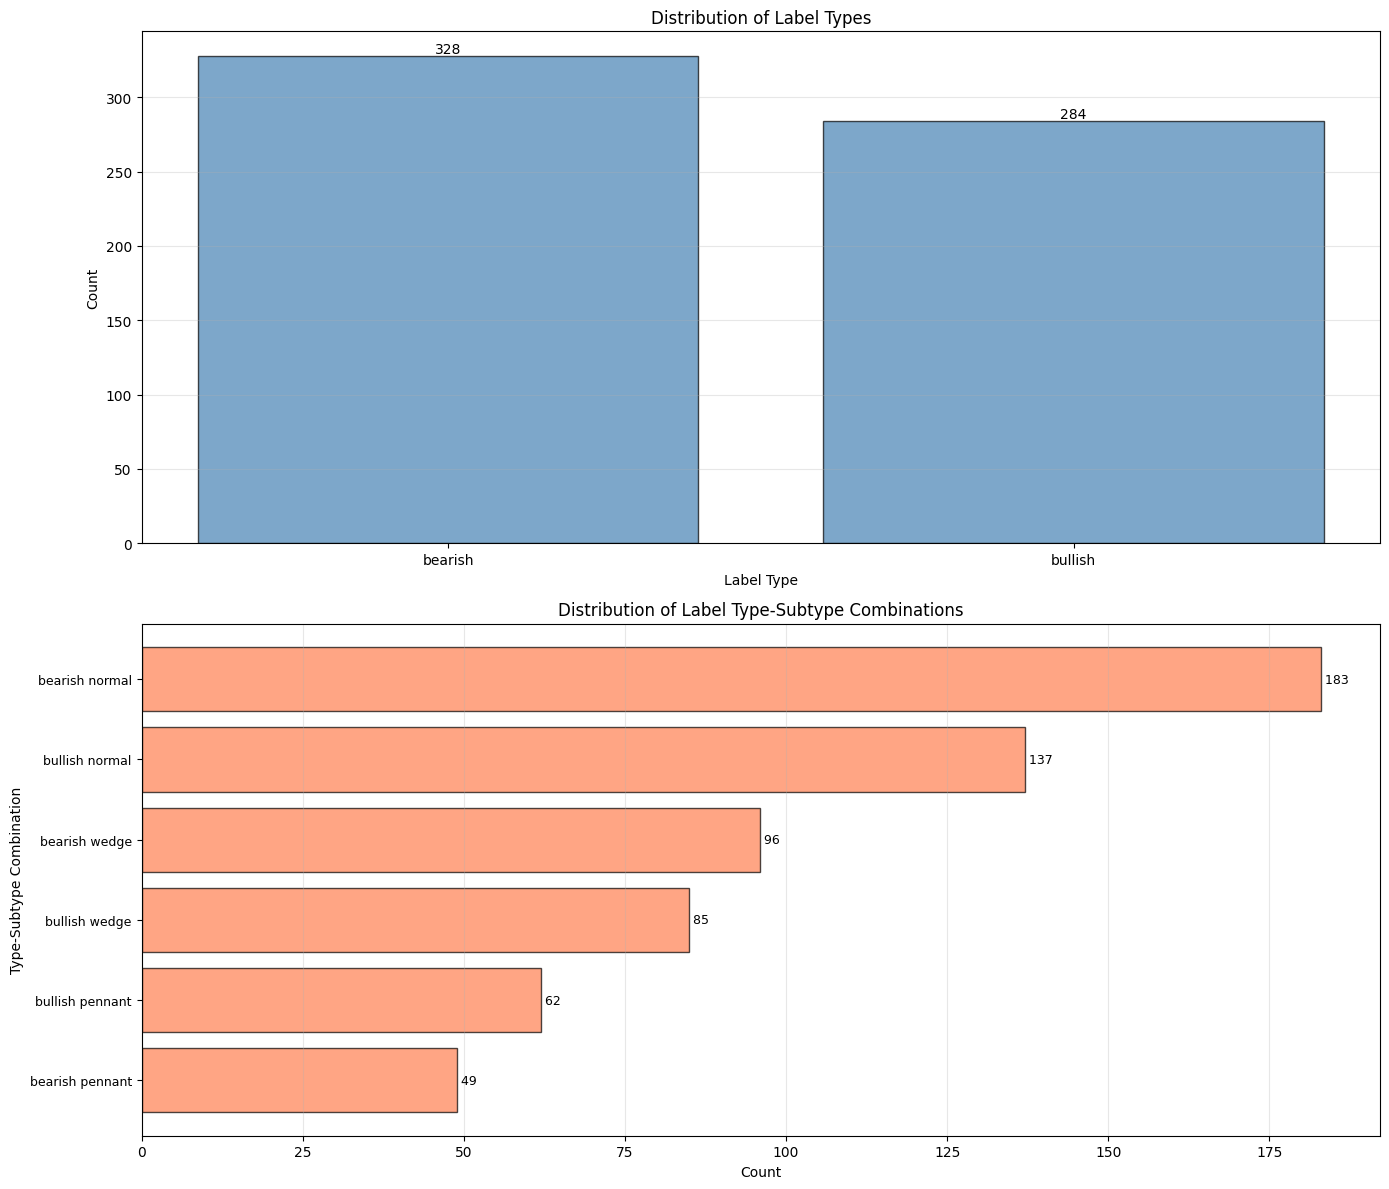


Label Type Summary:
Total labels: 612
Unique types: 2
Unique subtypes: 3
Unique type-subtype combinations: 6

Type breakdown:
  bearish: 328 (53.6%)
  bullish: 284 (46.4%)

Most common subtypes:
  normal: 320 (52.3%)
  wedge: 181 (29.6%)
  pennant: 111 (18.1%)


In [8]:
# Create a graph which shows the distribution of different types and subtypes of labels

def analyze_label_types(labels_json: dict):
    """
    Analyze the distribution of label types and subtypes.
    
    Args:
        labels_json: Dictionary with 'labels' key
    
    Returns:
        Dictionary with type/subtype counts
    """
    labels = labels_json.get("labels", [])
    
    type_counts = {}
    subtype_counts = {}
    type_subtype_counts = {}
    
    for label in labels:
        label_type = label.get('type', 'unknown')
        label_subtype = label.get('subtype', '')
        
        # Count types
        type_counts[label_type] = type_counts.get(label_type, 0) + 1
        
        # Count subtypes (only if not empty)
        if label_subtype:
            subtype_counts[label_subtype] = subtype_counts.get(label_subtype, 0) + 1
        
        # Count type-subtype combinations
        combination = f"{label_type}" if not label_subtype else f"{label_type} {label_subtype}"
        type_subtype_counts[combination] = type_subtype_counts.get(combination, 0) + 1
    
    return {
        'types': type_counts,
        'subtypes': subtype_counts,
        'combinations': type_subtype_counts
    }

def draw_label_type_distribution(labels_json: dict):
    """
    Draw visualizations of label type and subtype distributions.
    """
    analysis = analyze_label_types(labels_json)
    
    # Create subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    # Plot 1: Type distribution
    types = analysis['types']
    if types:
        sorted_types = sorted(types.items(), key=lambda x: x[1], reverse=True)
        type_names = [t[0] for t in sorted_types]
        type_counts = [t[1] for t in sorted_types]
        
        axes[0].bar(type_names, type_counts, color='steelblue', alpha=0.7, edgecolor='black')
        axes[0].set_xlabel('Label Type')
        axes[0].set_ylabel('Count')
        axes[0].set_title('Distribution of Label Types')
        axes[0].grid(True, alpha=0.3, axis='y')
        
        # Add count labels on bars
        for i, (name, count) in enumerate(sorted_types):
            axes[0].text(i, count, str(count), ha='center', va='bottom')
    
    # Plot 2: Type-Subtype combinations
    combinations = analysis['combinations']
    if combinations:
        sorted_combos = sorted(combinations.items(), key=lambda x: x[1], reverse=True)
        
        # Limit to top 20 for readability
        if len(sorted_combos) > 20:
            sorted_combos = sorted_combos[:20]
            axes[1].set_title('Top 20 Label Type-Subtype Combinations')
        else:
            axes[1].set_title('Distribution of Label Type-Subtype Combinations')
        
        combo_names = [c[0] for c in sorted_combos]
        combo_counts = [c[1] for c in sorted_combos]
        
        # Use horizontal bar chart for better label readability
        y_pos = np.arange(len(combo_names))
        axes[1].barh(y_pos, combo_counts, color='coral', alpha=0.7, edgecolor='black')
        axes[1].set_yticks(y_pos)
        axes[1].set_yticklabels(combo_names, fontsize=9)
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Type-Subtype Combination')
        axes[1].grid(True, alpha=0.3, axis='x')
        axes[1].invert_yaxis()  # Highest count at top
        
        # Add count labels on bars
        for i, count in enumerate(combo_counts):
            axes[1].text(count, i, f' {count}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    total_labels = sum(analysis['types'].values())
    print(f"\nLabel Type Summary:")
    print(f"Total labels: {total_labels}")
    print(f"Unique types: {len(analysis['types'])}")
    print(f"Unique subtypes: {len(analysis['subtypes'])}")
    print(f"Unique type-subtype combinations: {len(analysis['combinations'])}")
    
    print(f"\nType breakdown:")
    for label_type, count in sorted(analysis['types'].items(), key=lambda x: x[1], reverse=True):
        percentage = (count / total_labels * 100) if total_labels > 0 else 0
        print(f"  {label_type}: {count} ({percentage:.1f}%)")
    
    if analysis['subtypes']:
        print(f"\nMost common subtypes:")
        for subtype, count in sorted(analysis['subtypes'].items(), key=lambda x: x[1], reverse=True)[:10]:
            percentage = (count / total_labels * 100) if total_labels > 0 else 0
            print(f"  {subtype}: {count} ({percentage:.1f}%)")

# Load the labels and draw the type distribution graph
with open(labels_path, 'r', encoding='utf-8') as f:
    labels_data = json.load(f)

draw_label_type_distribution(labels_data)

In [16]:
# Adapt professor's code for normalizing labels (standardizing pole starts for flag patterns)
# Visualize the difference for one label at a time with a slider
# Keep changes in memory, don't overwrite label files

from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt

# Hyperparameter
N_BARS_LOOKBACK = 50  # How many candles to look back for pole search

def standardize_pole_starts(labels_json: dict):
    """
    Recalculate pole_start for all flag pattern labels using slope maximization.
    Adapted to work with the custom label structure.
    
    Args:
        labels_json: Dictionary with 'labels' and 'files' keys
    
    Returns:
        List of standardized labels with 'pole_start' field added
    """
    labels = labels_json.get("labels", [])
    files = labels_json.get("files", [])
    
    standardized_labels = []
    
    for label in labels:
        # Only process flag patterns
        label_type = label.get('type', '')
        label_subtype = label.get('subtype', '')
        
        # Determine if this is a bull or bear flag
        pattern_type = None
        if label_type == 'bullish':
            pattern_type = "BULL_FLAG"
        elif label_type == 'bearish':
            pattern_type = "BEAR_FLAG"
        else:
            # Not a flag pattern, skip
            continue
        
        try:
            # Load the CSV file for this label
            file_id = label['file']
            file_entry = next((f for f in files if f['id'] == file_id), None)
            
            if not file_entry:
                continue
            
            csv_path = os.path.join(data_out_dir, file_entry['normalized_file'])
            if not os.path.exists(csv_path):
                continue
            
            # Load OHLCV data with timestamp as index
            df = pd.read_csv(csv_path)
            time_col = df.columns[0]
            df[time_col] = pd.to_datetime(df[time_col])
            df.set_index(time_col, inplace=True)
            
            # Get flag start timestamp
            flag_start_ts = pd.to_datetime(label['start'])
            
            # Find nearest index position for flag start
            flag_start_idx_pos = df.index.get_indexer([flag_start_ts], method='nearest')[0]
            flag_start_bar = df.iloc[flag_start_idx_pos]
            
            # Variables to track best candidate
            best_pole_start_ts = None
            max_slope = -float('inf')
            
            # Search window (look back)
            for i in range(1, N_BARS_LOOKBACK + 1):
                candidate_idx_pos = flag_start_idx_pos - i
                
                # Check bounds
                if candidate_idx_pos < 0:
                    break
                
                candidate_bar = df.iloc[candidate_idx_pos]
                time_bars_elapsed = i
                
                # Calculate slope based on pattern type
                price_change = 0.0
                
                if pattern_type == "BULL_FLAG":
                    # Pole: Rising. Starts at flag top (high), pole begins at low
                    anchor_price = flag_start_bar['high']
                    candidate_price = candidate_bar['low']
                    price_change = anchor_price - candidate_price
                    
                elif pattern_type == "BEAR_FLAG":
                    # Pole: Falling. Starts at flag bottom (low), pole begins at high
                    anchor_price = flag_start_bar['low']
                    candidate_price = candidate_bar['high']
                    price_change = candidate_price - anchor_price
                
                # Update best candidate if slope is better
                if price_change > 0:
                    current_slope = price_change / time_bars_elapsed
                    
                    if current_slope > max_slope:
                        max_slope = current_slope
                        best_pole_start_ts = candidate_bar.name  # Get timestamp from index
            
            # Add standardized label if valid pole was found
            if best_pole_start_ts is not None:
                new_label = {
                    **label,  # Copy all original fields
                    'pole_start': best_pole_start_ts.strftime('%Y-%m-%d %H:%M'),
                    'calculated_slope': max_slope,
                    'pattern_type': pattern_type
                }
                standardized_labels.append(new_label)
            
        except Exception as e:
            file_id = label['file']
            file_entry = next((f for f in files if f['id'] == file_id), None)
            
            if not file_entry:
                continue
            
            csv_path = os.path.join(data_out_dir, file_entry['normalized_file'])
            print(f"Warning: Could not process label in {csv_path}: {e}")
            continue
    
    return standardized_labels


# Load labels data
labels_file_path = "./data/labels.json"
with open(labels_file_path, 'r', encoding='utf-8') as f:
    labels_data = json.load(f)

# Process labels
print("Standardizing pole starts for flag patterns...")
standardized_labels = standardize_pole_starts(labels_data)
print(f"Processed {len(standardized_labels)} flag pattern labels")


Standardizing pole starts for flag patterns...
Processed 555 flag pattern labels


In [17]:

def visualize_label_comparison(labels_json: dict, standardized_labels: list, label_idx: int = 0):
    """
    Visualize a single label comparing original vs standardized pole start.
    
    Args:
        labels_json: Original labels dictionary
        standardized_labels: List of standardized labels
        label_idx: Index of label to visualize
    """
    if label_idx >= len(standardized_labels):
        print("Invalid label index")
        return
    
    label = standardized_labels[label_idx]
    files = labels_json.get("files", [])
    
    # Load the CSV file
    file_id = label['file']
    file_entry = next((f for f in files if f['id'] == file_id), None)
    
    if not file_entry:
        print("File not found")
        return
    
    csv_path = os.path.join(data_out_dir, file_entry['normalized_file'])
    df = pd.read_csv(csv_path)
    time_col = df.columns[0]
    df[time_col] = pd.to_datetime(df[time_col])
    
    # Get timestamps
    flag_start = pd.to_datetime(label['start'])
    flag_end = pd.to_datetime(label['end'])
    pole_start = pd.to_datetime(label['pole_start'])
    
    # Find data range to display (some context before and after)
    start_idx = max(0, df[df[time_col] == pole_start].index[0] - 5)
    end_idx = min(len(df), df[df[time_col] == flag_end].index[0] + 5)
    
    df_display = df.iloc[start_idx:end_idx].copy()
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Plot candlesticks
    for idx, row in df_display.iterrows():
        color = 'green' if row['close'] >= row['open'] else 'red'
        # Body
        ax.plot([row[time_col], row[time_col]], [row['open'], row['close']], 
                color=color, linewidth=8, solid_capstyle='butt')
        # Wick
        ax.plot([row[time_col], row[time_col]], [row['low'], row['high']], 
                color=color, linewidth=1)
    
    # Highlight regions
    ax.axvspan(pole_start, flag_start, alpha=0.2, color='blue', label='Pole')
    ax.axvspan(flag_start, flag_end, alpha=0.2, color='orange', label='Flag')
    
    # Mark key points
    ax.axvline(pole_start, color='blue', linestyle='--', linewidth=2, label='Standardized Pole Start')
    ax.axvline(flag_start, color='orange', linestyle='--', linewidth=2, label='Flag Start')
    ax.axvline(flag_end, color='red', linestyle='--', linewidth=2, label='Flag End')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.set_title(f"Label {label_idx}: {label['pattern_type']} (Slope: {label['calculated_slope']:.4f})\n"
                 f"File: {file_entry['normalized_file']}")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print(f"\nLabel Details:")
    print(f"Type: {label['type']} {label['subtype']}")
    print(f"Pole Start: {label['pole_start']}")
    print(f"Flag Start: {label['start']}")
    print(f"Flag End: {label['end']}")
    print(f"Calculated Slope: {label['calculated_slope']:.6f}")


# Create interactive slider to browse through labels
if standardized_labels:
    interact(
        lambda idx: visualize_label_comparison(labels_data, standardized_labels, idx),
        idx=IntSlider(min=0, max=len(standardized_labels)-1, step=1, value=0, description='Label:')
    )
else:
    print("No flag patterns found to standardize")

interactive(children=(IntSlider(value=0, description='Label:', max=554), Output()), _dom_classes=('widget-inte…

In [18]:
import random
import numpy as np
import torch
from torch.utils.data import Dataset

WINDOW = 64
STRIDE = 8
NEG_POS_RATIO = 3 # no-flag : flag

# Pattern type to class ID mapping
PATTERN_TO_CLASS = {
    'BULL_FLAG': 1,
    'BEAR_FLAG': 2
}

def load_ohlc(file_id):
    """
    Returns OHLC data as numpy array of shape (N, 4)
    Columns: O, H, L, C
    """
    # Find the file entry
    file_entry = next((f for f in labels_data['files'] if f['id'] == file_id), None)
    if not file_entry:
        raise ValueError(f"File with id {file_id} not found")
    
    # Load the CSV file
    csv_path = os.path.join(data_out_dir, file_entry['normalized_file'])
    if not os.path.exists(csv_path):
        raise ValueError(f"CSV file not found: {csv_path}")
    
    df = pd.read_csv(csv_path)
    
    # Extract OHLC columns
    ohlc = df[['open', 'high', 'low', 'close']].values
    return ohlc.astype(np.float32)

def load_labels(file_id):
    """
    Returns list of labels as tuples: (start_idx, end_idx, class_id)
    where start_idx and end_idx are row indices in the CSV
    """
    # Find the file entry
    file_entry = next((f for f in labels_data['files'] if f['id'] == file_id), None)
    if not file_entry:
        return []
    
    # Load the CSV to get timestamps for index mapping
    csv_path = os.path.join(data_out_dir, file_entry['normalized_file'])
    df = pd.read_csv(csv_path)
    time_col = df.columns[0]
    
    # Find all labels for this file in standardized_labels
    file_labels = [l for l in standardized_labels if l['file'] == file_id]
    
    result = []
    for label in file_labels:
        # Get pole_start (or fall back to flag start) and flag end timestamps
        pole_start_ts = label.get('pole_start', label['start'])
        flag_end_ts = label['end']
        
        # Find corresponding row indices
        start_mask = df[time_col] == pole_start_ts
        end_mask = df[time_col] == flag_end_ts
        
        start_indices = df[start_mask].index
        end_indices = df[end_mask].index
        
        if len(start_indices) > 0 and len(end_indices) > 0:
            start_idx = start_indices[0]
            end_idx = end_indices[0]
            
            # Get class ID from pattern type
            pattern_type = label.get('pattern_type', 'BULL_FLAG')
            class_id = PATTERN_TO_CLASS.get(pattern_type, 1)
            
            result.append((start_idx, end_idx, class_id))
    
    return result

def window_label(start, end, labels, min_overlap=0.6):
    window_len = end - start
    best_overlap = 0
    best_class = 0  # no-flag

    for l_start, l_end, cls in labels:
        overlap = max(0, min(end, l_end) - max(start, l_start))
        frac = overlap / window_len

        if frac > best_overlap:
            best_overlap = frac
            best_class = cls

    if best_overlap >= min_overlap:
        return best_class
    return 0

def extract_features(ohlc_window):
    """
    Input: (T, 4)
    Output: (T, F)
    """
    O, H, L, C = ohlc_window.T

    returns = np.diff(np.log(C + 1e-8), prepend=0)
    body = C - O
    upper_wick = H - np.maximum(O, C)
    lower_wick = np.minimum(O, C) - L
    range_ = H - L

    feats = np.stack([
        returns,
        body,
        upper_wick,
        lower_wick,
        range_
    ], axis=1)

    # per-window normalization
    feats = (feats - feats.mean(axis=0)) / (feats.std(axis=0) + 1e-6)
    return feats.astype(np.float32)

def build_dataset(file_ids):
    positives = []
    negatives = []

    for fid in file_ids:
        ohlc = load_ohlc(fid)
        labels = load_labels(fid)
        N = len(ohlc)

        for start in range(0, N - WINDOW, STRIDE):
            end = start + WINDOW
            cls = window_label(start, end, labels)

            x = extract_features(ohlc[start:end])

            if cls == 0:
                negatives.append((x, cls))
            else:
                positives.append((x, cls))

    # subsample negatives
    k = min(len(negatives), NEG_POS_RATIO * len(positives))
    negatives = random.sample(negatives, k)

    data = positives + negatives
    random.shuffle(data)

    X = np.stack([d[0] for d in data])
    y = np.array([d[1] for d in data])

    return X, y

class FlagDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [25]:
import torch.nn as nn
from torch.utils.data import DataLoader

class FlagCNN(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv1d(num_features, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        # x: (B, T, F) → (B, F, T)
        x = x.transpose(1, 2)
        x = self.net(x).squeeze(-1)
        return self.fc(x)

def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for X, y in loader:
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

# Get unique file_ids from standardized_labels
file_ids = list(set(label['file'] for label in standardized_labels))
print(f"Found {len(file_ids)} unique files with flag patterns")

X, y = build_dataset(file_ids)
print(f"Dataset shape: X={X.shape}, y={y.shape}")
print(f"Class distribution: {np.bincount(y)}")

dataset = FlagDataset(X, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Determine number of classes from data
num_classes = len(np.unique(y))
print(f"Number of classes: {num_classes}")

model = FlagCNN(num_features=X.shape[2], num_classes=num_classes)

# class weights
class_counts = np.bincount(y)
weights = 1.0 / (class_counts + 1e-6)
weights = torch.tensor(weights, dtype=torch.float32)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(50):
    loss = train(model, loader, optimizer, criterion)
    print(f"Epoch {epoch}: loss={loss:.4f}")

Found 27 unique files with flag patterns
Dataset shape: X=(67788, 64, 5), y=(67788,)
Class distribution: [50841  6160 10787]
Number of classes: 3
Epoch 0: loss=1.0349
Epoch 1: loss=0.9625
Epoch 2: loss=0.8589
Epoch 3: loss=0.7141
Epoch 4: loss=0.5939
Epoch 5: loss=0.5068
Epoch 6: loss=0.4380
Epoch 7: loss=0.3821
Epoch 8: loss=0.3328
Epoch 9: loss=0.2951
Epoch 10: loss=0.2580
Epoch 11: loss=0.2306
Epoch 12: loss=0.2087
Epoch 13: loss=0.1837
Epoch 14: loss=0.1660
Epoch 15: loss=0.1544
Epoch 16: loss=0.1342
Epoch 17: loss=0.1223
Epoch 18: loss=0.1120
Epoch 19: loss=0.1054
Epoch 20: loss=0.0956
Epoch 21: loss=0.0862
Epoch 22: loss=0.0781
Epoch 23: loss=0.0772
Epoch 24: loss=0.0730
Epoch 25: loss=0.0655
Epoch 26: loss=0.0621
Epoch 27: loss=0.0613
Epoch 28: loss=0.0543
Epoch 29: loss=0.0530
Epoch 30: loss=0.0521
Epoch 31: loss=0.0452
Epoch 32: loss=0.0420
Epoch 33: loss=0.0465
Epoch 34: loss=0.0424
Epoch 35: loss=0.0432
Epoch 36: loss=0.0436
Epoch 37: loss=0.0364
Epoch 38: loss=0.0430
Epoch 

In [26]:
# Visualize baseline network predictions on random windows

from ipywidgets import interact, IntSlider
import torch.nn.functional as F

# Class names for display
CLASS_NAMES = {
    0: 'No Flag',
    1: 'Bull Flag',
    2: 'Bear Flag'
}

def sample_random_windows(file_ids, num_samples=20, model=None):
    """
    Sample random windows from the dataset with their ground truth labels.
    If model is provided, ensures ~50% are predicted as positive (flag patterns).
    Returns list of (file_id, start_idx, ohlc_window, features, ground_truth_class)
    """
    if model is None:
        # Simple random sampling if no model provided
        samples = []
        for _ in range(num_samples):
            fid = random.choice(file_ids)
            ohlc = load_ohlc(fid)
            labels = load_labels(fid)
            N = len(ohlc)
            
            if N < WINDOW:
                continue
            
            start = random.randint(0, N - WINDOW)
            end = start + WINDOW
            gt_class = window_label(start, end, labels)
            ohlc_window = ohlc[start:end]
            features = extract_features(ohlc_window)
            
            samples.append((fid, start, ohlc_window, features, gt_class))
        
        return samples
    
    # Sample larger pool and filter by model predictions
    pool_size = num_samples * 5  # Sample 5x more to ensure enough positives
    pool_samples = []
    
    print(f"Sampling {pool_size} windows for filtering...")
    for _ in range(pool_size):
        fid = random.choice(file_ids)
        ohlc = load_ohlc(fid)
        labels = load_labels(fid)
        N = len(ohlc)
        
        if N < WINDOW:
            continue
        
        start = random.randint(0, N - WINDOW)
        end = start + WINDOW
        gt_class = window_label(start, end, labels)
        ohlc_window = ohlc[start:end]
        features = extract_features(ohlc_window)
        
        pool_samples.append((fid, start, ohlc_window, features, gt_class))
    
    # Classify all samples
    print("Running model predictions on pool...")
    predicted_positive = []  # Model predicts flag (class 1 or 2)
    predicted_negative = []  # Model predicts no flag (class 0)
    
    for sample in pool_samples:
        fid, start, ohlc_window, features, gt_class = sample
        pred_class, _ = predict_window(model, features)
        
        if pred_class > 0:  # Predicted as flag (bull or bear)
            predicted_positive.append(sample)
        else:  # Predicted as no flag
            predicted_negative.append(sample)
    
    print(f"Found {len(predicted_positive)} predicted positives, {len(predicted_negative)} predicted negatives")
    
    # Balance the samples: 50% predicted positive, 50% predicted negative
    target_positive = num_samples // 2
    target_negative = num_samples - target_positive
    
    # Randomly select from each category
    selected_positive = random.sample(predicted_positive, min(target_positive, len(predicted_positive)))
    selected_negative = random.sample(predicted_negative, min(target_negative, len(predicted_negative)))
    
    samples = selected_positive + selected_negative
    random.shuffle(samples)
    
    print(f"Selected {len(selected_positive)} predicted positives, {len(selected_negative)} predicted negatives")
    
    return samples

def predict_window(model, features):
    """
    Run model inference on a single window.
    Returns predicted class and confidence scores.
    """
    model.eval()
    with torch.no_grad():
        # Convert to tensor and add batch dimension
        x = torch.tensor(features).unsqueeze(0)  # (1, T, F)
        
        # Get logits
        logits = model(x)
        
        # Get probabilities
        probs = F.softmax(logits, dim=1).squeeze(0).numpy()
        
        # Get predicted class
        pred_class = int(torch.argmax(logits, dim=1).item())
    
    return pred_class, probs

def visualize_prediction(model, sample_idx, samples):
    """
    Visualize a single window with ground truth and model prediction.
    """
    if sample_idx >= len(samples):
        print("Invalid sample index")
        return
    
    fid, start_idx, ohlc_window, features, gt_class = samples[sample_idx]
    
    # Get model prediction
    pred_class, probs = predict_window(model, features)
    
    # Get file info
    file_entry = next((f for f in labels_data['files'] if f['id'] == fid), None)
    if not file_entry:
        print("File not found")
        return
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), 
                                     gridspec_kw={'height_ratios': [3, 1]})
    
    # Plot candlesticks
    for i, row in enumerate(ohlc_window):
        o, h, l, c = row
        color = 'green' if c >= o else 'red'
        # Body
        ax1.plot([i, i], [o, c], color=color, linewidth=8, solid_capstyle='butt')
        # Wick
        ax1.plot([i, i], [l, h], color=color, linewidth=1)
    
    # Add ground truth label
    correct = '✓' if pred_class == gt_class else '✗'
    title_color = 'green' if pred_class == gt_class else 'red'
    
    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel('Price')
    ax1.set_title(f"Sample {sample_idx} | File: {file_entry['normalized_file']} | Start: {start_idx}\n"
                  f"Ground Truth: {CLASS_NAMES[gt_class]} | Predicted: {CLASS_NAMES[pred_class]} {correct}",
                  color=title_color, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Plot confidence scores
    class_indices = list(CLASS_NAMES.keys())[:len(probs)]
    class_labels = [CLASS_NAMES[i] for i in class_indices]
    colors = ['green' if i == pred_class else 'gray' for i in class_indices]
    
    bars = ax2.bar(class_labels, probs, color=colors, alpha=0.7, edgecolor='black')
    
    # Highlight ground truth with a marker
    if gt_class < len(class_indices):
        ax2.scatter(gt_class, probs[gt_class], color='red', s=200, marker='*', 
                   label='Ground Truth', zorder=5)
    
    ax2.set_ylabel('Confidence')
    ax2.set_title('Model Confidence Scores')
    ax2.set_ylim(0, 1)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add confidence values on bars
    for i, (bar, prob) in enumerate(zip(bars, probs)):
        ax2.text(bar.get_x() + bar.get_width()/2, prob, f'{prob:.3f}',
                ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed info
    print(f"\nDetailed Information:")
    print(f"File ID: {fid}")
    print(f"Window: [{start_idx}, {start_idx + WINDOW})")
    print(f"Ground Truth: {CLASS_NAMES[gt_class]} (class {gt_class})")
    print(f"Prediction: {CLASS_NAMES[pred_class]} (class {pred_class})")
    print(f"Confidence: {probs[pred_class]:.4f}")
    print(f"Result: {'CORRECT' if pred_class == gt_class else 'INCORRECT'}")

# Sample random windows with balanced predictions
print("Sampling windows with balanced model predictions...")
random.seed(42)  # For reproducibility
test_samples = sample_random_windows(file_ids, num_samples=50, model=model)
print(f"Sampled {len(test_samples)} windows (balanced by model predictions)")

# Calculate accuracy on sampled windows
correct = 0
for _, _, _, features, gt_class in test_samples:
    pred_class, _ = predict_window(model, features)
    if pred_class == gt_class:
        correct += 1

accuracy = correct / len(test_samples) if test_samples else 0
print(f"Accuracy on sampled windows: {accuracy:.2%} ({correct}/{len(test_samples)})")

# Create interactive slider
if test_samples:
    interact(
        lambda idx: visualize_prediction(model, idx, test_samples),
        idx=IntSlider(min=0, max=len(test_samples)-1, step=1, value=0, description='Sample:')
    )
else:
    print("No samples to visualize")

Sampling windows with balanced model predictions...
Sampling 250 windows for filtering...
Running model predictions on pool...
Found 7 predicted positives, 243 predicted negatives
Selected 7 predicted positives, 25 predicted negatives
Sampled 32 windows (balanced by model predictions)
Accuracy on sampled windows: 81.25% (26/32)


interactive(children=(IntSlider(value=0, description='Sample:', max=31), Output()), _dom_classes=('widget-inte…

In [ ]:
import subprocess
subprocess.run(['python', '../src/01-data-preprocessing.py'])

preprocess()